In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import các thư viện cần thiết**

In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

**2. Đọc file dữ liệu GAS và chia dataset theo tỉ lệ 7:2:1**

In [ ]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/GAS.csv')
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

In [ ]:
df

,Price
0,98700
1,102900
2,99600
3,97500
4,97200
...,...
1246,92900
1247,92800
1248,92000
1249,92000


**3. Dùng model ARIMA để train data**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.9 MB/s eta 0:00:00


In [ ]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = False)
# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15724.687, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15725.422, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15721.602, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15721.191, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15723.423, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15721.589, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15720.694, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15722.393, Time=1.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15723.305, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15725.302, Time=0.81 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15718.692, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15719.187, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=15720.391, Time=0.78 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=15721.263, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

**4. Quá trình test**

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test),typ='levels', dynamic=True)


**5. Quá trình validate**

In [ ]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val),typ='levels', dynamic=True)

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [ ]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days), typ='levels', dynamic=True)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[99158.65118688 99221.61810963 99221.61810963 99221.61810963
 99221.61810963 99221.61810963 99221.61810963 99221.61810963
 99221.61810963 99221.61810963 99221.61810963 99221.61810963
 99221.61810963 99221.61810963 99221.61810963 99221.61810963
 99221.61810963 99221.61810963 99221.61810963 99221.61810963
 99221.61810963 99221.61810963 99221.61810963 99221.61810963
 99221.61810963 99221.61810963 99221.61810963 99221.61810963
 99221.61810963 99221.61810963]


***7.Đánh giá độ chính xác thuật toán***

In [ ]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 6230.234065019664
Testing RMSE: 11507.104823301359
Validation MAPE: 5.61657062750282
Testing MAPE: 8.961936164951483
Validation MAE: 5749.278702889599
Testing MAE: 9982.913928005044


**8. Vẽ biểu đồ**

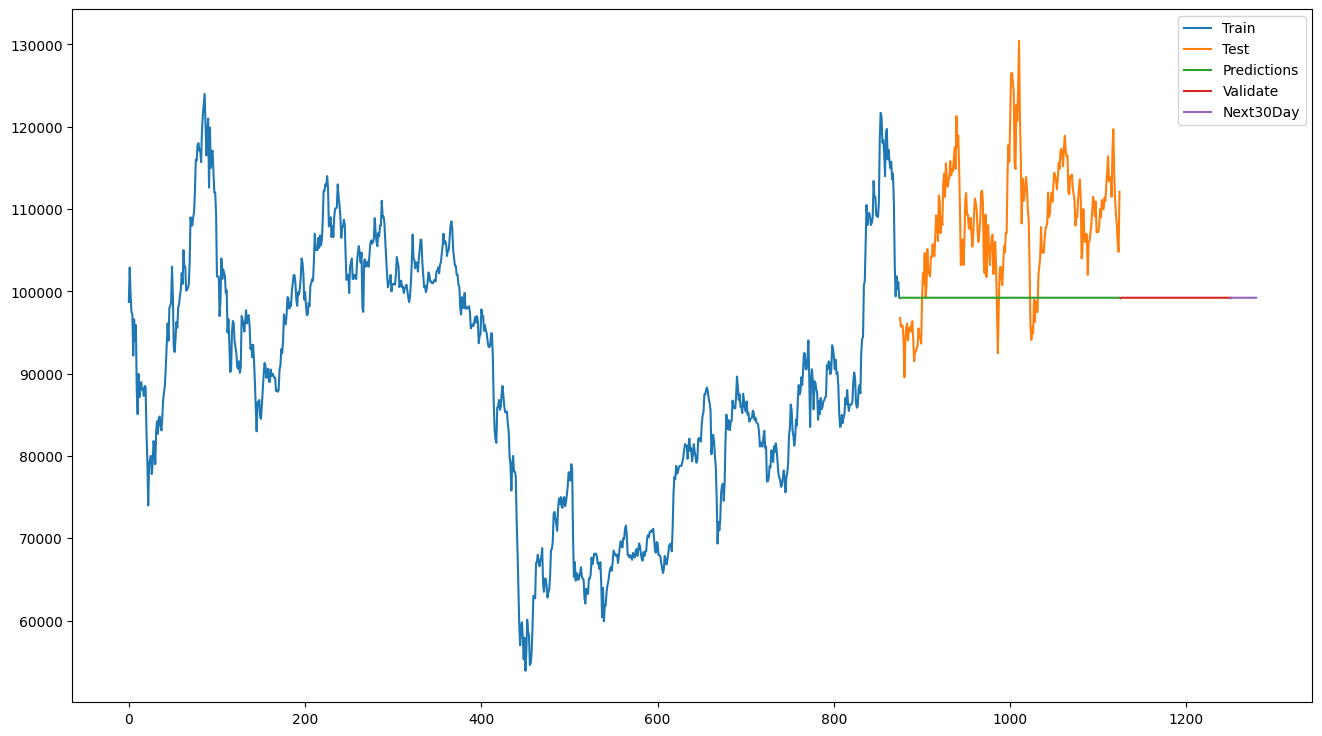

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()